# Basic Package Mangement

In [1]:
#install.packages("pacman") # Execute this once.
require(pacman)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.6.3"

### Clearing and unloading packages

In [53]:
# Run this block, when done coding or before starting coding.
p_unload(all)
detach("package:datasets", unload=TRUE)
rm(list=ls()) # removes all previous stored variables

The following packages have been unloaded:
readxl, ResourceSelection, magrittr, mosaic, ggridges, mosaicData, ggformula, ggstance, Matrix, lattice, forcats, stringr, dplyr, purrr, readr, tidyr, tibble, ggplot2, tidyverse, pacman



### Loading packages

In [2]:
pacman::p_load(pacman, tidyverse, mosaic, magrittr, ResourceSelection)

# Initializing the dataframe

In [4]:
library("readxl")
df <- read_excel("data/DeathsDK160321.xlsx")
df

interval,age,infected,tested,female_deaths,male_deaths,tot_deaths,comorbidity,infected_fem,infected_male,tot_male,tot_fem,tot_num
1,0-9,15400,395142,0,1,1,1,7372,8028,313571,297559,611130
2,10-19,34025,605344,0,0,0,0,16626,17399,348964,331889,680853
3,20-29,41545,688922,0,0,0,0,21296,20249,397572,381907,779479
4,30-39,30514,604186,4,2,6,3,15615,14899,352231,341194,693425
5,40-49,32482,646070,3,4,7,5,17345,15137,376117,375174,751291
6,50-59,31843,660087,21,32,53,37,16507,15336,402188,398825,801013
7,60-69,17558,490990,73,122,195,153,8562,8996,327021,338282,666262
8,70-79,10910,370426,229,395,624,516,5378,5532,272021,300894,572915
9,80-89,5760,140654,441,523,964,784,3330,2430,99560,135830,235390
10,90+,1805,28610,325,220,545,433,1277,528,13237,32228,45455


### Plotting and testing

In [5]:
mortality = df %>% 
  filter(age != "Alle") %>% 
  select(age, infected, tested, tot_deaths) %>% 
  mutate(`Mortality given Infected` = tot_deaths/infected) %>% 
  rename(Age = age) %>% 
  select(-tested,-tot_deaths)

In [6]:
mortality

Age,infected,Mortality given Infected
0-9,15400,6.493506e-05
10-19,34025,0.000000e+00
20-29,41545,0.000000e+00
30-39,30514,1.966311e-04
40-49,32482,2.155040e-04
50-59,31843,1.664416e-03
60-69,17558,1.110605e-02
70-79,10910,5.719523e-02
80-89,5760,1.673611e-01
90+,1805,3.019391e-01


In [7]:
Binomial_Bootstrap = function(p,n, B = 10000){
  #Generate new MEAN data
  p_B = rbinom(B,n,p)/n
}

In [8]:
Quantiles_Binomial = mortality %>% 
  mutate(Bootstraps = map2(`Mortality given Infected`, infected, Binomial_Bootstrap, B = 10000)) %>% 
  mutate(Quantiles = map(Bootstraps, quantile, c(0.025,0.975))) %>% 
  mutate(`2.5% quantile` = unlist(map(Quantiles, function(x){x[1]}))) %>% 
  mutate(`97.5% quantile` = unlist(map(Quantiles, function(x){x[2]}))) %>% 
  select(Age, `2.5% quantile`, `97.5% quantile`)

In [9]:
Quantiles_Binomial

Age,2.5% quantile,97.5% quantile
0-9,0.000000e+00,0.0001948052
10-19,0.000000e+00,0.0000000000
20-29,0.000000e+00,0.0000000000
30-39,6.554368e-05,0.0003604903
40-49,6.157256e-05,0.0004002217
50-59,1.224759e-03,0.0021354772
60-69,9.625242e-03,0.0127007632
70-79,5.288726e-02,0.0615948671
80-89,1.578125e-01,0.1770876736
90+,2.814404e-01,0.3235457064


In [10]:
Bernoulli_Bootstrap = function(p,n, B = 10000){
  #Generate new MEAN data
  p_B = replicate(B,mean(rbernoulli(n,p)))
}

In [11]:
Quantiles_Bernoulli = mortality %>% 
  mutate(Bootstraps = map2(`Mortality given Infected`, infected, Bernoulli_Bootstrap, B = 1000)) %>% 
  mutate(Quantiles = map(Bootstraps, quantile, c(0.025,0.975))) %>% 
  mutate(`2.5% quantile` = unlist(map(Quantiles, function(x){x[1]}))) %>% 
  mutate(`97.5% quantile` = unlist(map(Quantiles, function(x){x[2]}))) %>% 
  select(Age, `2.5% quantile`, `97.5% quantile`)

In [12]:
Quantiles_Bernoulli

Age,2.5% quantile,97.5% quantile
0-9,0.000000e+00,0.0002597403
10-19,0.000000e+00,0.0000000000
20-29,0.000000e+00,0.0000000000
30-39,6.554368e-05,0.0003604903
40-49,6.157256e-05,0.0003694354
50-59,1.256163e-03,0.0021040731
60-69,9.568288e-03,0.0127007632
70-79,5.288726e-02,0.0616888176
80-89,1.574609e-01,0.1767361111
90+,2.819945e-01,0.3235595568


In [13]:
Quantiles_Bernoulli %<>% mutate(Bootstrap = "Bernoulli")
Quantiles_Binomial %<>% mutate(Bootstrap = "Binomial")

In [14]:
Quantiles = rbind(Quantiles_Bernoulli,Quantiles_Binomial)

In [15]:
Quantiles

Age,2.5% quantile,97.5% quantile,Bootstrap
0-9,0.000000e+00,0.0002597403,Bernoulli
10-19,0.000000e+00,0.0000000000,Bernoulli
20-29,0.000000e+00,0.0000000000,Bernoulli
30-39,6.554368e-05,0.0003604903,Bernoulli
40-49,6.157256e-05,0.0003694354,Bernoulli
50-59,1.256163e-03,0.0021040731,Bernoulli
60-69,9.568288e-03,0.0127007632,Bernoulli
70-79,5.288726e-02,0.0616888176,Bernoulli
80-89,1.574609e-01,0.1767361111,Bernoulli
90+,2.819945e-01,0.3235595568,Bernoulli


Warning message:
"attributes are not identical across measure variables;
they will be dropped"

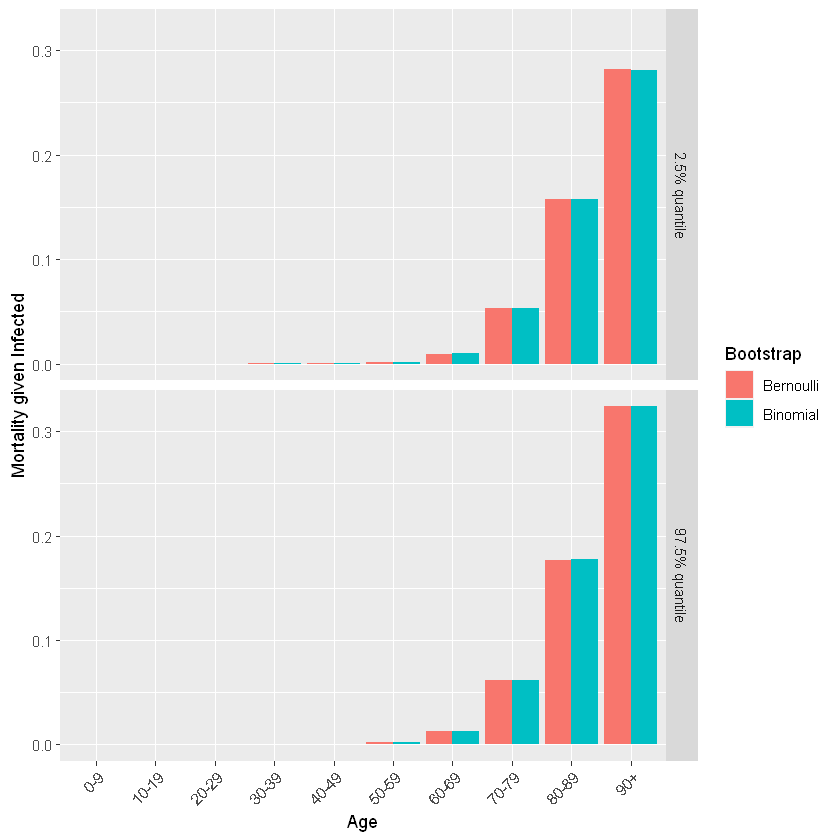

In [16]:
Quantiles %>% gather("Quantile","Value", -Age,-Bootstrap) %>% 
  ggplot(aes(x = Age, y = Value, fill = Bootstrap)) + 
  geom_bar(stat = "identity",position=position_dodge()) + 
  facet_grid(vars(Quantile)) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) + 
  ylab("Mortality given Infected")

# Logistisk regression på en kategorisk variabel

Vi vil undersøge, hvad sandsynligheden er for at man dør givet en specifik alder.
Dog kan der opstå et problem, da modellen oftest operere på kontinuerete forklarende variable.

Da kan det være nødvendigt at undersøge, hvorvidt det har nogen betydning i vores tilfælde. Vi har nemlig en variabel der originalt er kontinuert - altså variablen alder, men denne variabel er gjort diskret ved at afrunde alderen til kun at indeholde år. Efterfølgende er alderen yderligere opdelt kategorisk, så der er tale om en aldersgruppe.

Har dette nogen signifikant betydning for resultatet?

In [17]:
DKpop <- read_excel("data/folketal.xlsx") # Indlæs datasættet for den befolkning og dets fordeling af alder.
DKpop %<>% mutate(P = total/sum(total)) # Tilføjer en søjle med sandsynlighed for at være en given alder.
head(DKpop)

age,total,male,female,P
0,61191,31303,29888,0.01047783
1,61663,31758,29905,0.01055865
2,61967,31909,30058,0.01061071
3,62185,31852,30333,0.01064803
4,62844,32402,30442,0.01076088
5,59740,30627,29113,0.01022937


In [18]:
# En funktioner der returnere en tabel af personer med alder konverteret til en kontinuert værdi og 
# en bernoulli værdi der indikere om personen døde af covid-19 eller ej.
Sampler = function(n, beta_0, beta_1, uniform_displace = T){
    X = with(DKpop, sample(age, n, replace = T, prob = P))
    if (uniform_displace){
        X = X + runif(n,0,1)
    }
    P_X = ilogit(beta_0 + beta_1*X)
    Y = rbernoulli(n,P_X)
    return(tibble(age = X,dead = Y))
}

In [19]:
alpha = -9 # Vores intercept, som glm modellen skal forsøge at estimere.
beta = 0.1 # Hældningskoefficenten, som glm modellen skal forsøge at estimere.

Sampled_Data = Sampler(1000,alpha,beta) # Kalder funktionen, hvor 1000 personer samples.
head(Sampled_Data, 10)

age,dead
13.2685553,FALSE
0.7229839,FALSE
53.5402180,FALSE
42.6883068,FALSE
81.2418034,FALSE
57.9526978,FALSE
74.7738943,FALSE
67.0044457,FALSE
49.8180460,FALSE
80.5251978,FALSE


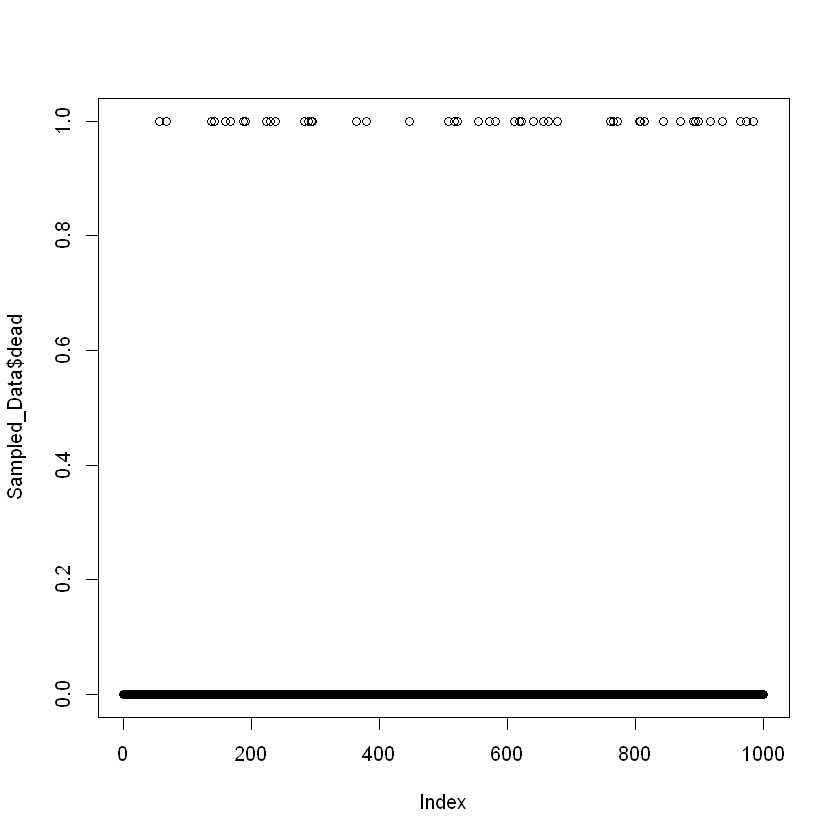

In [20]:
plot(Sampled_Data$dead)

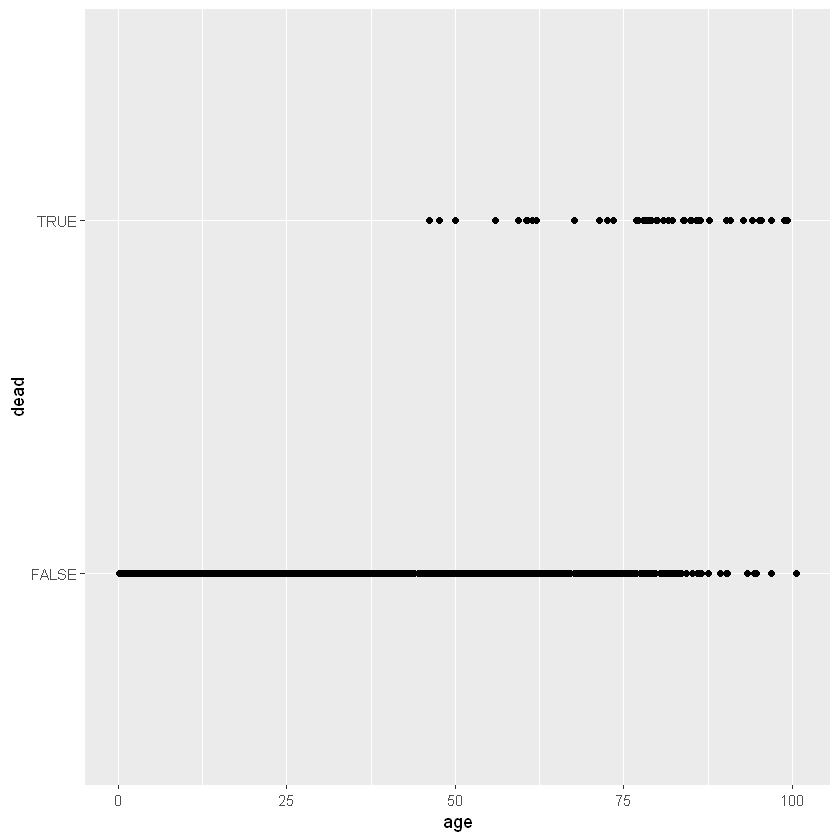

In [21]:
Sampled_Data %>% 
  ggplot(aes(x = age, y = dead)) + geom_point()

In [22]:
# En tabel, der indeholder sandsynligheden for at dø givet man er x år gammel.
Logit_Curve = tibble(age = 0:120, `P(Dead|Age)` = ilogit(alpha + beta*0:120)+1)

head(Logit_Curve)
tail(Logit_Curve)

age,P(Dead|Age)
0,1.000123
1,1.000136
2,1.000151
3,1.000167
4,1.000184
5,1.000203


age,P(Dead|Age)
115,1.924142
116,1.930862
117,1.937027
118,1.942676
119,1.947846
120,1.952574


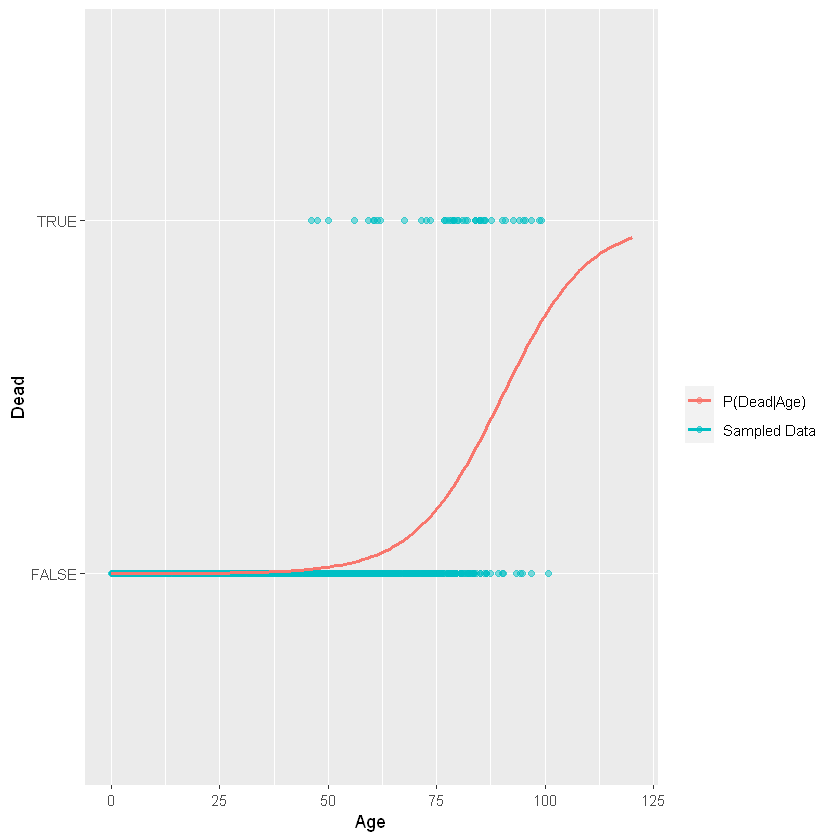

In [23]:
Sampled_Data %>%
    ggplot(aes(x = age, y = dead, color = "Sampled Data")) + geom_point(alpha = 0.5) + 
    geom_line(data = Logit_Curve, aes(x = age, y = `P(Dead|Age)`, color = "P(Dead|Age)"), size = .87, inherit.aes = F) + 
    xlab("Age") + ylab("Dead") + labs(color = "")

In [24]:
Sampled_Data %<>% mutate(age_truncated = floor(age/10)*10) # Tilføjer en søjle med trunkerede alder.
head(Sampled_Data)

age,dead,age_truncated
13.2685553,FALSE,10
0.7229839,FALSE,0
53.5402180,FALSE,50
42.6883068,FALSE,40
81.2418034,FALSE,80
57.9526978,FALSE,50


In [120]:
model <- glm(dead ~ 1, family = "binomial", data = Sampled_Data)
#summary(model)

In [25]:
# Model for kontinuert alder.
glm.main <- glm(dead ~ age, family = "binomial", data = Sampled_Data)
summary(glm.main)


Call:
glm(formula = dead ~ age, family = "binomial", data = Sampled_Data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.62891  -0.23105  -0.08258  -0.02828   3.11603  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.81933    1.01763  -9.649  < 2e-16 ***
age          0.10766    0.01333   8.076  6.7e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 385.17  on 999  degrees of freedom
Residual deviance: 247.04  on 998  degrees of freedom
AIC: 251.04

Number of Fisher Scoring iterations: 8


In [121]:
# Model for trunkeret alder.
glm.truncated <- glm(dead ~ age_truncated, family = "binomial", data = Sampled_Data)
summary(glm.truncated)


Call:
glm(formula = dead ~ age_truncated, family = "binomial", data = Sampled_Data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.72683  -0.21489  -0.07956  -0.02933   3.08674  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -8.74963    0.87079 -10.048  < 2e-16 ***
age_truncated  0.09986    0.01226   8.147 3.73e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 385.17  on 999  degrees of freedom
Residual deviance: 254.53  on 998  degrees of freedom
AIC: 258.53

Number of Fisher Scoring iterations: 8


In [125]:
glm.test <- glm(dead ~ age + age_truncated, family = "binomial", data = Sampled_Data)
#summary(glm.test)

In [27]:
`P(Age)` = DKpop$P
`P(Dead|Age)` = ilogit(alpha + beta*DKpop$age)
(`P(Dead)` = sum(`P(Dead|Age)`*`P(Age)`))

[1] 0.0501071

In [122]:
anova(model, glm.main, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
999,385.1674,NA,NA,NA
998,247.0425,1,138.125,6.843158e-32


In [123]:
anova(model, glm.truncated, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
999,385.1674,NA,NA,NA
998,254.5317,1,130.6357,2.974774e-30


In [124]:
anova(glm.main, glm.truncated, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
998,247.0425,NA,NA,NA
998,254.5317,0,-7.489232,NA


In [126]:
anova(glm.main, glm.test, test="Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
998,247.0425,NA,NA,NA
997,245.6084,1,1.434054,0.2311039


## Assess the performance of the model

https://www.guru99.com/r-generalized-linear-model.html

The confusion matrix is a better choice to evaluate the classification performance compared with other metrics. The general idea is to count the number of times True instances are classified are False.

In [29]:
predict <- predict(glm.main, Sampled_Data, type = 'response') # Beregn forudsigelserne for response sandsynligheden.
# confusion matrix
table_mat <- table(Sampled_Data$dead, predict > 0.5) # Hvis forudsigelserne er større end 0.5 returner 1 ellers 0.
table_mat # Søjlerne er selve forudsigelsen, hvor rækkerne er, hvad forudsigelsen burde værre.

       
        FALSE TRUE
  FALSE   947    5
  TRUE     41    7

Calculating the model accuracy by summing the true positive + true negative over the total observation

In [30]:
accuracy_Test <- sum(diag(table_mat)) / sum(table_mat)
accuracy_Test

[1] 0.954

Repeating same procedure for the other model.

In [31]:
predict.trunc <- predict(glm.truncated, Sampled_Data, type = 'response') # Beregn forudsigelserne for response sandsynligheden.
# confusion matrix
table_mat.trunc <- table(Sampled_Data$dead, predict.trunc > 0.5) # Hvis forudsigelserne er større end 0.5 returner 1 ellers 0.
table_mat.trunc # Søjlerne er selve forudsigelsen, hvor rækkerne er, hvad forudsigelsen burde værre.

       
        FALSE TRUE
  FALSE   945    7
  TRUE     39    9

In [32]:
accuracy_Test.trunc <- sum(diag(table_mat.trunc)) / sum(table_mat.trunc)
accuracy_Test.trunc

[1] 0.954

#### Beregning af forklaringsgraden $R^2$

https://stats.stackexchange.com/questions/46345/how-to-calculate-goodness-of-fit-in-glm-r/46358

In [33]:
with(summary(glm.main), 1 - deviance/null.deviance)

[1] 0.3586102

In [34]:
with(summary(glm.truncated), 1 - deviance/null.deviance)

[1] 0.3391661

### Hosmer-Lemeshow Goodness of Fit

https://www.theanalysisfactor.com/r-glm-model-fit/

How well our model fits depends on the difference between the model and the observed data.  One approach for binary data is to implement a Hosmer Lemeshow goodness of fit test.

In [62]:
(hl.main <- hoslem.test(Sampled_Data$dead, fitted(glm.main)))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  Sampled_Data$dead, fitted(glm.main)
X-squared = 11.984, df = 8, p-value = 0.1519


In [63]:
(hl.truncated <- hoslem.test(Sampled_Data$dead, fitted(glm.truncated)))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  Sampled_Data$dead, fitted(glm.truncated)
X-squared = 8.0539, df = 8, p-value = 0.4282


In [65]:
cbind(hl.main$expected, hl.main$observed)

,yhat0,yhat1,y0,y1
"[5.52e-05,0.000141]",99.99101,0.008993534,100,0
"(0.000141,0.00039]",99.97661,0.023388937,100,0
"(0.00039,0.000965]",99.93329,0.066706840,100,0
"(0.000965,0.0021]",99.86230,0.137698686,100,0
"(0.0021,0.00531]",99.65122,0.348778194,100,0
"(0.00531,0.0118]",99.16249,0.837507022,97,3
"(0.0118,0.0243]",98.26368,1.736324560,99,1
"(0.0243,0.0559]",96.24712,3.752882345,95,5
"(0.0559,0.161]",89.77889,10.221105665,96,4
"(0.161,0.735]",69.13339,30.866614215,65,35


In [66]:
cbind(hl.truncated$expected, hl.truncated$observed)

,yhat0,yhat1,y0,y1
"[4.99e-05,0.000163]",99.98957,0.01043079,100,0
"(0.000163,0.000434]",99.97303,0.02697136,100,0
"(0.000434,0.00109]",99.92890,0.07110452,100,0
"(0.00109,0.00202]",99.84991,0.15009343,100,0
"(0.00202,0.00484]",99.66679,0.33320970,100,0
"(0.00484,0.0113]",99.19345,0.80654513,98,2
"(0.0113,0.0248]",98.30043,1.69957400,97,3
"(0.0248,0.0535]",96.40004,3.59995702,96,4
"(0.0535,0.165]",90.01039,9.98961447,96,4
"(0.165,0.769]",68.68750,31.31249972,65,35


Our models appears to fit well because we have no significant difference between the models and the observed data (i.e. the p-value is above 0.05).

As with all measures of model fit, we’ll use this as just one piece of information in deciding how well this model fits.  It doesn’t work well in very large or very small data sets, but is often useful nonetheless.

## Har alder og/eller køn en betydning for dødeligheden?

In [37]:
temp_df <- df %>% 
  filter(age != "Alle")
unfolded_data = pmap_dfr(temp_df, 
                      function(interval, tot_deaths, infected, infected_male,infected_fem, male_deaths, female_deaths,...) {
                           data.frame(age_group = interval,
                                      dead = c(rep(1, tot_deaths), rep(0, infected - tot_deaths)),
                                      gender = c(rep("Male", male_deaths),
                                                rep("Female", female_deaths),
                                                rep("Male",infected_male-male_deaths),
                                                rep("Female",infected_fem-female_deaths)))
                                     
                      }
)

In [38]:
nrow(unfolded_data)

[1] 221842

In [39]:
str(unfolded_data)

'data.frame':	221842 obs. of  3 variables:
 $ age_group: num  1 1 1 1 1 1 1 1 1 1 ...
 $ dead     : num  1 0 0 0 0 0 0 0 0 0 ...
 $ gender   : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 2 2 2 2 ...


In [40]:
unfolded_data$age_group <- as.factor(unfolded_data$age_group)
unfolded_data$dead <- as.factor(unfolded_data$dead)

In [41]:
str(unfolded_data)

'data.frame':	221842 obs. of  3 variables:
 $ age_group: Factor w/ 10 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ dead     : Factor w/ 2 levels "0","1": 2 1 1 1 1 1 1 1 1 1 ...
 $ gender   : Factor w/ 2 levels "Female","Male": 2 2 2 2 2 2 2 2 2 2 ...


In [42]:
head(unfolded_data)

age_group,dead,gender
1,1,Male
1,0,Male
1,0,Male
1,0,Male
1,0,Male
1,0,Male


# Hypotesetest

#### Chi i anden test $\chi^2$-test

$$H_0: \text{Køn er uafhængig af dødeligheden}$$

$$H_a: \text{Køn er afhængig af dødeligheden}$$

In [116]:
groupby_gender <- unfolded_data %>% group_by(gender)
groupby_gender <- groupby_gender %>% summarise(
    not_dead = nrow(unfolded_data) - sum(as.integer(dead == 1)),
    dead = sum(as.integer(dead == 1))
) 
groupby_gender
(chi.gender <- chisq.test(groupby_gender %>% select(-gender)))

gender,not_dead,dead
Female,220746,1096
Male,220543,1299



	Pearson's Chi-squared test with Yates' continuity correction

data:  groupby_gender %>% select(-gender)
X-squared = 17.13, df = 1, p-value = 3.491e-05


In [117]:
chi.gender$expected

not_dead,dead
220644.5,1197.5
220644.5,1197.5


$$H_0: \text{Aldersgruppen er uafhængig af dødeligheden}$$

$$H_a: \text{Aldersgruppen er afhængig af dødeligheden}$$

In [118]:
groupby_age <- unfolded_data %>% group_by(age_group)
groupby_age <- groupby_age %>% summarise(
    not_dead = length(as.integer(age_group)) - sum(as.integer(dead == 1)),
    dead = sum(as.integer(dead == 1))
) 
groupby_age
(chi.age <- chisq.test(groupby_age %>% select(-age_group)))

age_group,not_dead,dead
1,15399,1
2,34025,0
3,41545,0
4,30508,6
5,32475,7
6,31790,53
7,17363,195
8,10286,624
9,4796,964
10,1260,545



	Pearson's Chi-squared test

data:  groupby_age %>% select(-age_group)
X-squared = 31648, df = 9, p-value < 2.2e-16


In [119]:
chi.age$expected

not_dead,dead
15233.742,166.25797
33657.667,367.33294
41096.481,448.51865
30184.572,329.42829
32131.325,350.67476
31499.224,343.77613
17368.444,189.55567
10792.216,117.78405
5697.815,62.18480
1785.513,19.48673


### t.test

$$H_0: \text{Aldersgruppen er uafhængig af dødeligheden}$$

$$H_a: \text{Aldersgruppen er afhængig af dødeligheden}$$

In [43]:
dead <- subset(unfolded_data, dead == 1)
alive <- subset(unfolded_data, dead == 0)
mean(as.integer(dead$age_group))
mean(as.integer(alive$age_group))

[1] 8.71023

[1] 4.296363

In [44]:
t.test(as.integer(alive$age_group), as.integer(dead$age_group), alternative="two.sided", conf.level = 0.95)


	Welch Two Sample t-test

data:  as.integer(alive$age_group) and as.integer(dead$age_group)
t = -204.8, df = 2609.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.456127 -4.371606
sample estimates:
mean of x mean of y 
 4.296363  8.710230 


Det ses med et 95% konfidensniveau, at de der overlever er signifikant yngre end de der dør... Omkring 4 aldergrupper sepperere dem. Alder har dermed en betydning for dødeligheden.

$$H_0: \text{Køn er uafhængig af dødeligheden}$$

$$H_a: \text{Køn er afhængig af dødeligheden}$$

In [45]:
men <- subset(unfolded_data, gender == "Male")
women <- subset(unfolded_data, gender == "Female")
mean(as.integer(men$dead == 1))
mean(as.integer(women$dead == 1))

[1] 0.0119686

[1] 0.00967275

In [46]:
t.test(as.integer(men$dead == 1), as.integer(women$dead == 1), alternative="two.sided", conf.level = 0.95)


	Welch Two Sample t-test

data:  as.integer(men$dead == 1) and as.integer(women$dead == 1)
t = 5.2192, df = 217102, p-value = 1.799e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.001433687 0.003158011
sample estimates:
 mean of x  mean of y 
0.01196860 0.00967275 


Det ses med et 95% konfidensniveau, at kvinders dødelighed er signifikant lavere end mændendes. Køn har dermed en betydning for dødeligheden.

Disse test er (måske) ikke specielt gode for den type data vi arbejder med og derfor anvender vi glm modellere istedet for at konkludere, hvorvidt alder og køn har en signifikant betydning for dødeligheden.

### GLM testing

In [53]:
model.default <- glm(dead ~ 1, family = "binomial", data=unfolded_data)
#summary(model.default)

In [54]:
model.age <- glm(dead ~ age_group, family = "binomial", data=unfolded_data)
#summary(model.age)

In [55]:
model.gender <- glm(dead ~ gender, family = "binomial", data=unfolded_data)
#summary(model.gender)

In [50]:
model.age_and_gender <- glm(dead ~ age_group + gender, family = "binomial", data=unfolded_data)
summary(model.age_and_gender)


Call:
glm(formula = dead ~ age_group + gender, family = "binomial", 
    data = unfolded_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9981  -0.0491  -0.0177   0.0000   4.3368  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -9.98864    1.00049  -9.984  < 2e-16 ***
age_group2  -11.90939  157.76669  -0.075  0.93983    
age_group3  -11.89564  142.76818  -0.083  0.93360    
age_group4    1.12682    1.08017   1.043  0.29686    
age_group5    1.23131    1.06910   1.152  0.24943    
age_group6    3.26813    1.00944   3.238  0.00121 ** 
age_group7    5.15888    1.00263   5.145 2.67e-07 ***
age_group8    6.85232    1.00089   6.846 7.58e-12 ***
age_group9    8.10960    1.00069   8.104 5.32e-16 ***
age_group10   8.96628    1.00148   8.953  < 2e-16 ***
genderMale    0.58479    0.04579  12.772  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

 

In [51]:
model.age_interakt_gender <- glm(dead ~ age_group * gender, family = "binomial", data=unfolded_data)
summary(model.age_interakt_gender)


Call:
glm(formula = dead ~ age_group * gender, family = "binomial", 
    data = unfolded_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0383  -0.0505  -0.0186   0.0000   4.2404  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)
(Intercept)            -2.157e+01  3.405e+02  -0.063    0.949
age_group2              3.008e-06  4.090e+02   0.000    1.000
age_group3              3.008e-06  3.950e+02   0.000    1.000
age_group4              1.330e+01  3.405e+02   0.039    0.969
age_group5              1.290e+01  3.405e+02   0.038    0.970
age_group6              1.490e+01  3.405e+02   0.044    0.965
age_group7              1.681e+01  3.405e+02   0.049    0.961
age_group8              1.845e+01  3.405e+02   0.054    0.957
age_group9              1.969e+01  3.405e+02   0.058    0.954
age_group10             2.049e+01  3.405e+02   0.060    0.952
genderMale              1.258e+01  3.405e+02   0.037    0.971
age_group2:genderMale  -1.258e+

In [56]:
#anova(model.default, model.age, test = "Chisq")
#anova(model.default, model.gender, test = "Chisq")
#anova(model.age, model.gender, test = "Chisq")
#anova(model.age, model.age_and_gender, test = "Chisq")
anova(model.age_and_gender, model.age_interakt_gender, test = "Chisq")

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
221831,15226.15,NA,NA,NA
221822,15220.23,9,5.917161,0.7481797


#### Ressourcer til yderligere undersøgelse

https://www.cdc.gov/csels/dsepd/ss1978/lesson3/section3.html#:~:text=An%20age%2Dspecific%20mortality%20rate,age%20group%20in%20the%20population.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4028711/

https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/files/documents/2020/Jan/un_1955_age_and_sex_patterns_of_mortality_-_model_life-tables_for_under-developed_countries_0.pdf

https://www.demogr.mpg.de/books/drm/009/12.pdf

https://www.sciencedirect.com/science/article/pii/S2352827319300680